# Konut Fiyatlarının Tahmini için Spark ile Regresyon Modeli Oluşturulması
## Amaç ve Kapsam
Tanımlanan veri seti üzerinde konut fiyatlarının tahminlenmesi için Spark ML kütüphanesi kullanılarak PySpark ile bir regresyon modeli oluşturulacaktır.

## Veri Kümesi
Veri kümesi: California Housing Prices
Veri hakkında detaylı bilgi ve indirmek için aşağıdaki sayfa kullanılmıştır:

https://www.kaggle.com/datasets/camnugent/california-housing-prices

Verinin bazı örnek alanları aşağıda verilmiştir:
1. **longitude** : Bir evin ne kadar batıda olduğunun bir ölçüsü; daha yüksek bir değer daha batıdadır.
2. **latitude** : Bir evin ne kadar kuzeyde olduğunun bir ölçüsü; daha yüksek bir değer daha kuzeydedir.
3. **housingMedianAge** : Bir bloktaki bir evin medyan yaşı; daha düşük bir sayı daha yeni bir binadır.
4. **totalRooms** : Bir bloktaki toplam oda sayısı.
5. **totalBedrooms** : Bir bloktaki toplam yatak odası sayısı.
6. **population** : Bir blokta ikamet eden toplam kişi sayısı.
7. **households** : Bir blok için bir ev biriminde ikamet eden bir grup insan olan toplam hane sayısı.
8. **medianIncome** : Bir konut bloğundaki haneler için medyan gelir (on binlerce ABD Doları cinsinden ölçülmüştür).
9. **medianHouseValue** : Bir blok içindeki haneler için medyan ev değeri (ABD Doları cinsinden ölçülmüştür).
10. **oceanProximity** : Evin okyanusa/denize göre konumu.


Makine öğrenmesi modeli ile tahminlenmesi hedeflenen veri alanı:
- median_house_value

# Drive Mount ve Pyspark Yüklenmesi

- Bu çalışmada Colab ortamı kullanılmıştır.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849766 sha256=df27182b4cb57a5f72940e9e57b0d199853ed02612e9fafc208f46eabe92ab50
  Stored in directory: /root/.cache/pip/wheels/8d/28/22/5dbae8a8714ef046cebd320d0ef7c92f5383903cf854c15c0c
Successfully built pyspark


# Gerekli Import'lar

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.regression import LinearRegression,DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor,GBTRegressor
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler, Imputer, StandardScaler, MinMaxScaler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Spark Session Başlatılması ve Verinin Çekilmesi

In [ ]:
from pyspark.sql import SparkSession
spark  = SparkSession.builder.appName('Dataframe').getOrCreate()

In [ ]:
# Veriyi yükleyin.
dataset = spark.read.csv('/content/drive/MyDrive/VYU-Spark_Odev/data/housing.csv', inferSchema=True, header=True)
dataset.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [ ]:
dataset.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.0035317

# Verideki Boş Değerlerin Kontrol Edilmesi

- Bu çalışmada veriseti ile ilgili önişlemlerin bazıları verinin bütün hali üzerinden uygulanıp modele verileceği zaman test ve train olarak bölünmüştür.

- Imputer gerekliliğini kontrol etmek için boş değerlerin sayısına bakılmıştır.

In [ ]:
from pyspark.sql.functions import col, count, when

# Tüm sütunlardaki NULL değerleri kontrol et
dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



# Imputing

- Gerekli sütuna Imputing işlemi uygulanmıştır.

In [ ]:
# Eksik değerleri doldurma (median)
imputer = Imputer(inputCols=["total_bedrooms"], outputCols=["total_bedrooms_imputed"]).setStrategy("median")
dataset = imputer.fit(dataset).transform(dataset)
dataset.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms_imputed|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|                 129.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|                1106.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|                 190.0|
|  -122.25|   37.85|              

# StringIndexer

- Metinsel olan "ocean_proximity" sütunu StringIndexer uygulaması yapılarak sayısal değere çevrilmiştir.

In [ ]:
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")
dataset = indexer.fit(dataset).transform(dataset)
dataset.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms_imputed|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------------+---------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|                 129.0|                  3.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|                1106.0|                  3.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177

- Son olarak tekrar boş değerler kontol edilmiştir.

In [ ]:
# Tüm sütunlardaki NULL değerleri kontrol et
dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms_imputed|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------------+---------------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|                     0|                    0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------------+---------------------+



- Burada eğitim aşamasında kullanılacak olan sütunlar bir dizi içinde tanımlanmıştır. Bu dizi VectorAssembler'e verilmek üzere hazırlanmıştır.

In [ ]:
features = ["longitude","latitude","housing_median_age","total_rooms","total_bedrooms_imputed",
                  "population","households","median_income","ocean_proximity_index"]

# Verinin Hazırlanması

- Yukarıda tanımlanan "features" dizisindeki değişlenler bir araya toplanmış. İkinci sütun olarak da hedef değişken olan "median_house_value" sütunu "label" adıyla bir "data" içinde birleştirilmiştir.

In [ ]:
assembler = VectorAssembler(inputCols = features, outputCol="features")
data = assembler.transform(dataset)
data = data.withColumnRenamed("median_house_value", "label")
data.select("features","label").show(10,truncate=False)

+-----------------------------------------------------------+--------+
|features                                                   |label   |
+-----------------------------------------------------------+--------+
|[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,3.0]    |452600.0|
|[-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3.0]|358500.0|
|[-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,3.0]   |352100.0|
|[-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,3.0]   |341300.0|
|[-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0]   |342200.0|
|[-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,3.0]    |269700.0|
|[-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,3.0]  |299200.0|
|[-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.12,3.0]    |241400.0|
|[-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,3.0]  |226700.0|
|[-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,3.0]  |261100.0|
+-----------------------------------------------------------+--------+
only s

- Tüm veri hala bütün halindedir. Model aşamasında verinin içinden gereken sütunlar çekilerek işlem yapılacaktır.

In [ ]:
data.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- label: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- total_bedrooms_imputed: double (nullable = true)
 |-- ocean_proximity_index: double (nullable = false)
 |-- features: vector (nullable = true)



- StandardScaler, sayısal verilerin ortalamasını 0, standart sapmasını 1 yaparak, farklı ölçeklerdeki değişkenleri dengeleyerek modelin daha hızlı ve stabil öğrenmesini sağlar. Bu, özellikle mesafe tabanlı ve lineer modellerde performansı artırır.

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
data = scaler.fit(data).transform(data)
data.select("features", "scaledFeatures").show(truncate=False)

+-----------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                   |scaledFeatures                                                                                                                                                               |
+-----------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,3.0]    |[-61.00726959606955,17.734477624640412,3.2577023016083064,0.40337085073160667,0.30758821710917267,0.2843362208866199,0.3295584480852433,4.382095394195227,2.9864139366491074]|
|[-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,

In [ ]:
data.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+----------------------+---------------------+--------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   label|ocean_proximity|total_bedrooms_imputed|ocean_proximity_index|            features|      scaledFeatures|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+----------------------+---------------------+--------------------+--------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|       NEAR BAY|                 129.0|                  3.0|[-122.23,37.88,41...|[-61.007269596069...|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|358500.0|       NEAR BAY|             

## Kategorik Değişkenler

- "ocean_proximity_index" sütunu bir kategorik değişkendir. Bu değişkene gerekli işlemler aşağıda uygulanmıştır.

In [ ]:
categorical_assembler = VectorAssembler(inputCols=["ocean_proximity_index"], outputCol="catFeatures")
data = categorical_assembler.transform(data)
data.select("catFeatures").show(10,truncate=False)

+-----------+
|catFeatures|
+-----------+
|[3.0]      |
|[3.0]      |
|[3.0]      |
|[3.0]      |
|[3.0]      |
|[3.0]      |
|[3.0]      |
|[3.0]      |
|[3.0]      |
|[3.0]      |
+-----------+
only showing top 10 rows



- Kategorik değişkenin normalize eğilmesi için MinMaxScaler kullanılmıştır.  Bu, bazı makine öğrenmesi modellerinin sayısal ölçeklerle daha iyi çalışmasını sağlayacaktır.

In [ ]:
minmax = MinMaxScaler(inputCol="catFeatures", outputCol="catFeaturesScaled")
data = minmax.fit(data).transform(data)
data.select("catFeatures", "catFeaturesScaled").show(10,truncate=False)

+-----------+-----------------+
|catFeatures|catFeaturesScaled|
+-----------+-----------------+
|[3.0]      |[0.75]           |
|[3.0]      |[0.75]           |
|[3.0]      |[0.75]           |
|[3.0]      |[0.75]           |
|[3.0]      |[0.75]           |
|[3.0]      |[0.75]           |
|[3.0]      |[0.75]           |
|[3.0]      |[0.75]           |
|[3.0]      |[0.75]           |
|[3.0]      |[0.75]           |
+-----------+-----------------+
only showing top 10 rows



## Sayısal ve Kategorik Feature'ların Birleştirilmesi

In [ ]:
merge_assembler = VectorAssembler(inputCols=["scaledFeatures", "catFeaturesScaled"], outputCol="final_features")
final_dataset = merge_assembler.transform(data).select("final_features", "label")
final_dataset.show(10,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|final_features                                                                                                                                                                    |label   |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[-61.00726959606955,17.734477624640412,3.2577023016083064,0.40337085073160667,0.30758821710917267,0.2843362208866199,0.3295584480852433,4.382095394195227,2.9864139366491074,0.75]|452600.0|
|[-61.002278409814444,17.725114120086744,1.668579227653035,3.2540109878905406,2.637151690873992,2.1201592122632746,2.9764882057222772,4.369567902917918,2.9864139366491074,0.75]   |358500.0|
|[-61.012260782324645,17.720432367809913,4.1317199

In [ ]:
print(f"Satır Sayısı: {final_dataset.count()}, Sütun Sayısı: {len(final_dataset.columns)}")

Satır Sayısı: 20640, Sütun Sayısı: 2


## Verinin Bölünmesi

- %20 test ve %80 train olacak şekilde veri bölünmüştür.

In [ ]:
splits = final_dataset.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1]
train_rows = train.count()
test_rows = test.count()
print("Training Rows:", train_rows, " Testing Rows:", test_rows)

Training Rows: 16569  Testing Rows: 4071


- test verisi için "label" sütunu adı "trueLabel" olarak değiştirilmiştir.

In [ ]:
test = test.withColumnRenamed("label", "trueLabel")
test.show(10,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|final_features                                                                                                                                                                   |trueLabel|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|[-62.040445150874945,19.569724517158633,1.509666920257508,1.2247805831305147,1.316191440653204,1.146175200965319,1.2502296681329073,1.0420451462893732,1.9909426244327384,0.5]   |85800.0  |
|[-62.00550684708926,18.979823730277776,4.131719992283705,1.234864854398805,1.0801353670577925,1.0172525666502676,1.137761308865721,1.6215205726418362,1.9909426244327384,0.5]    |106700.0 |
|[-62.00550684708926,19.10623104175225,4.131719992

# Modellerin Oluşuturlması

- Bu adımda 4 farklı model train verisi ile fit edilmiştir. Daha sonrasında en başarılı model değerlendirme metrikleri ile belirlenecektir.

In [ ]:
# **Linear Regression (L1 + L2 Regularization)**
lr = LinearRegression(
    labelCol="label", featuresCol="final_features",
    maxIter=100, regParam=0.1, elasticNetParam=0.8
)
lr_model = lr.fit(train)

# **Decision Tree Regressor**
dt = DecisionTreeRegressor(
    labelCol="label", featuresCol="final_features",
    maxDepth=10, minInstancesPerNode=5, maxBins=32
)
dt_model = dt.fit(train)

# **Random Forest Regressor**
rf = RandomForestRegressor(
    labelCol="label", featuresCol="final_features",
    numTrees=200, maxDepth=12, featureSubsetStrategy="auto"
)
rf_model = rf.fit(train)

# **Gradient Boosted Tree Regressor**
gbt = GBTRegressor(
    labelCol="label", featuresCol="final_features",
    maxIter=50, maxDepth=5, stepSize=0.1
)
gbt_model = gbt.fit(train)

## Modeller ile Tahminleme Yapılması ve Sonuçların İncelenmesi

- Her bir model için test verisi ile predict yapılıp sonuçları tablo halinde çıkartırlmış ve scatterPlot şeklinde görselleştirilmiştir.



***************📌 Linear Regression Modeli Sonuçları ***************
+---------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|trueLabel|prediction        |final_features                                                                                                                                                                   |id |
+---------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|85800.0  |64667.941588028334|[-62.040445150874945,19.569724517158633,1.509666920257508,1.2247805831305147,1.316191440653204,1.146175200965319,1.2502296681329073,1.0420451462893732,1.9909426244327384,0.5]   |0  |
|106700.0 |191548.2115067849 |[-62.00550684708926,18.979823730277776,4.1317199

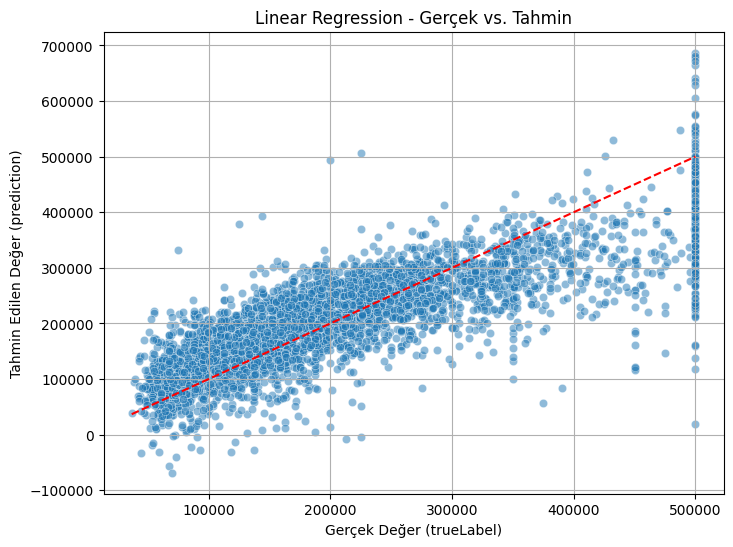



***************📌 Decision Tree Modeli Sonuçları ***************
+---------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|trueLabel|prediction        |final_features                                                                                                                                                                   |id |
+---------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|85800.0  |85259.42028985507 |[-62.040445150874945,19.569724517158633,1.509666920257508,1.2247805831305147,1.316191440653204,1.146175200965319,1.2502296681329073,1.0420451462893732,1.9909426244327384,0.5]   |0  |
|106700.0 |434105.77777777775|[-62.00550684708926,18.979823730277776,4.13171999228

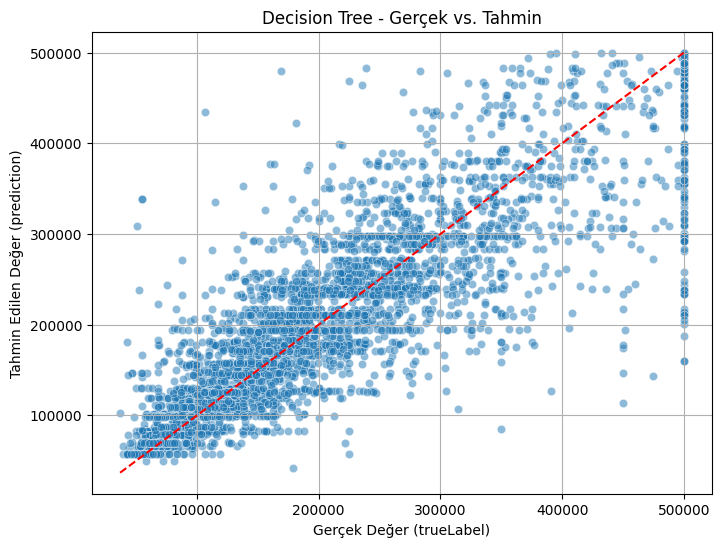



***************📌 Random Forest Modeli Sonuçları ***************
+---------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|trueLabel|prediction        |final_features                                                                                                                                                                   |id |
+---------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|85800.0  |84786.64725946441 |[-62.040445150874945,19.569724517158633,1.509666920257508,1.2247805831305147,1.316191440653204,1.146175200965319,1.2502296681329073,1.0420451462893732,1.9909426244327384,0.5]   |0  |
|106700.0 |173798.9071199601 |[-62.00550684708926,18.979823730277776,4.13171999228

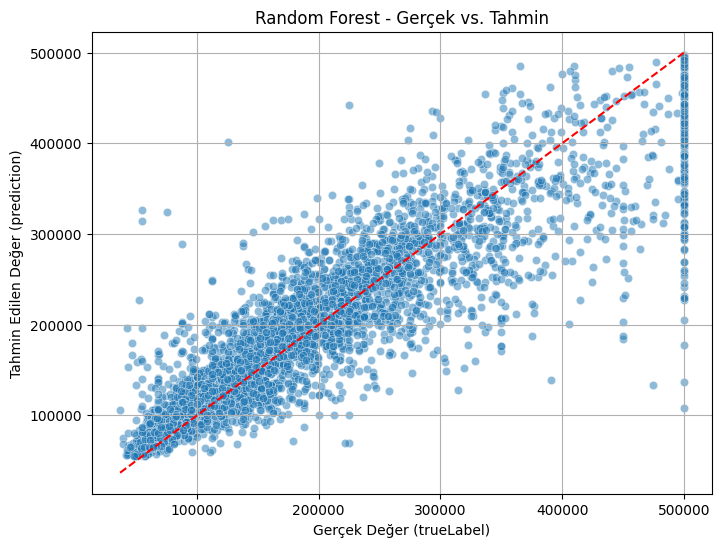



***************📌 Gradient Boosting Tree Modeli Sonuçları ***************
+---------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|trueLabel|prediction        |final_features                                                                                                                                                                   |id |
+---------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|85800.0  |80174.82818583291 |[-62.040445150874945,19.569724517158633,1.509666920257508,1.2247805831305147,1.316191440653204,1.146175200965319,1.2502296681329073,1.0420451462893732,1.9909426244327384,0.5]   |0  |
|106700.0 |210660.83059373076|[-62.00550684708926,18.979823730277776,4.13

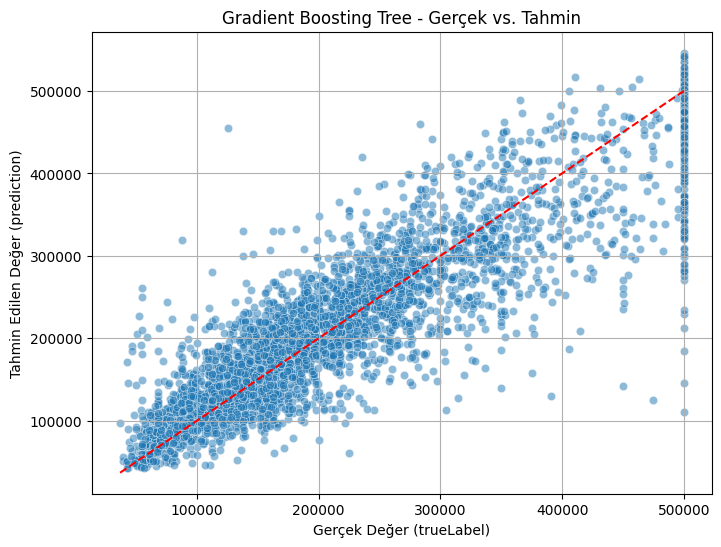

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import monotonically_increasing_id

# **Tahmin, tablo yazdırma ve görselleştirme fonksiyonu**
def predict_and_visualize(model, model_name):
    # Model tahmini yap
    prediction = model.transform(test)
    predicted = prediction.select("trueLabel", "prediction", "final_features")  # Gerekli sütunları al

    # ID sütunu ekleyerek tabloyu yazdır
    predicted = predicted.withColumn("id", monotonically_increasing_id())
    print(f"\n\n***************📌 {model_name} Modeli Sonuçları ***************")
    predicted.show(10, truncate=False)  # İlk 10 tahmini göster

    # **Pandas'a çevir ve scatter plot çiz**
    df = predicted.toPandas()

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df["trueLabel"], y=df["prediction"], alpha=0.5)
    plt.xlabel("Gerçek Değer (trueLabel)")
    plt.ylabel("Tahmin Edilen Değer (prediction)")
    plt.title(f"{model_name} - Gerçek vs. Tahmin")
    plt.plot([df["trueLabel"].min(), df["trueLabel"].max()],
             [df["trueLabel"].min(), df["trueLabel"].max()], 'r--')  # Y=x doğrusu
    plt.grid(True)
    plt.show()

    return predicted

# **Tüm modeller için tahminleri uygula ve görselleştir**
predicted_lr = predict_and_visualize(lr_model, "Linear Regression")
predicted_dt = predict_and_visualize(dt_model, "Decision Tree")
predicted_rf = predict_and_visualize(rf_model, "Random Forest")
predicted_gbt = predict_and_visualize(gbt_model, "Gradient Boosting Tree")


## Değerlendirme Metriklerinin Hesaplanması

- Modelin tahminlerine ve gerçek değerlere bakılarak RMSE ve R^2 (accuracy) hesaplanmıştır.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# **RMSE ve R² hesaplama fonksiyonu**
def evaluate_model(predicted_df):
    evaluator_rmse = RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="r2")

    rmse = evaluator_rmse.evaluate(predicted_df)  # RMSE hesaplama
    r2 = evaluator_r2.evaluate(predicted_df)  # R² hesaplama

    return rmse, r2

# **Her modelin tahmin sonuçları üzerinde RMSE ve R² hesaplama**
rmse_lr, r2_lr = evaluate_model(predicted_lr)
print(f"Linear Regression Modeli için \n RMSE: {rmse_lr} --- R²: {r2_lr}\n\n")

rmse_dt, r2_dt = evaluate_model(predicted_dt)
print(f"Decision Tree Modeli için \n RMSE: {rmse_dt} --- R²: {r2_dt}\n\n")

rmse_rf, r2_rf = evaluate_model(predicted_rf)
print(f"Random Forest Modeli için \n RMSE: {rmse_rf} --- R²: {r2_rf}\n\n")

rmse_gbt, r2_gbt = evaluate_model(predicted_gbt)
print(f"Gradient Boosting Tree Modeli için \n RMSE: {rmse_gbt} --- R²: {r2_gbt}\n\n")


Linear Regression Modeli için 
 RMSE: 69861.03834621211 --- R²: 0.6291350353291096


Decision Tree Modeli için 
 RMSE: 60813.233902276166 --- R²: 0.7189769565852444


Random Forest Modeli için 
 RMSE: 53623.18632841101 --- R²: 0.7815002380003285


Gradient Boosting Tree Modeli için 
 RMSE: 53160.18250785202 --- R²: 0.7852571751342903




# Pipeline Oluşturulması

Son olarak çalışma boyunca yapılan işlemlerin toplarlandığı ve ek iyileştirmeler içeren aşağıdaki kod yazılmıştır. Bu çalışmada ;

1) Önişleme adımları Pipeline haline getirilip veriye uygulanmıştır.

2) Daha iyi başarı skorları elde edebilmek için  Grid Search yöntemiyle farklı parametre kombinasyonları denenmiş ve TrainValidationSplit kullanılarak en iyi model belirlenmiştir.

3) Model performans değerlendirmesi için daha önceki uygulandığı gibi RMSE ve R^2 (accuracy) metrikleri hesaplanmıştır.

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, MinMaxScaler, Imputer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql import SparkSession

# Spark Session oluşturma
spark = SparkSession.builder.appName('Dataframe').getOrCreate()

# Veriyi yükle
dataset = spark.read.csv('/content/drive/MyDrive/VYU-Spark_Odev/data/housing.csv', inferSchema=True, header=True)

# Pipeline bileşenleri
imputer = Imputer(inputCols=["total_bedrooms"], outputCols=["total_bedrooms_imputed"]).setStrategy("median")
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")

features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms_imputed",
            "population", "households", "median_income", "ocean_proximity_index"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

categorical_assembler = VectorAssembler(inputCols=["ocean_proximity_index"], outputCol="catFeatures")
minmax = MinMaxScaler(inputCol="catFeatures", outputCol="catFeaturesScaled")

merge_assembler = VectorAssembler(inputCols=["scaledFeatures", "catFeaturesScaled"], outputCol="final_features")

# Pipeline oluşturma
pipeline = Pipeline(stages=[imputer, indexer, assembler, scaler, categorical_assembler, minmax, merge_assembler])
processed_data = pipeline.fit(dataset).transform(dataset).select("final_features", col("median_house_value").alias("label"))




In [ ]:
# Modeller
lr = LinearRegression(labelCol="label", featuresCol="final_features")
dt = DecisionTreeRegressor(labelCol="label", featuresCol="final_features")
rf = RandomForestRegressor(labelCol="label", featuresCol="final_features")
gbt = GBTRegressor(labelCol="label", featuresCol="final_features")

# Parametre Grid'leri
grids = {
    lr: ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1, 0.5]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build(),
    dt: ParamGridBuilder().addGrid(dt.maxDepth, [5, 10, 15]).addGrid(dt.minInstancesPerNode, [1, 5, 10]).build(),
    rf: ParamGridBuilder().addGrid(rf.numTrees, [100, 200]).addGrid(rf.maxDepth, [10, 15]).build(),
    gbt: ParamGridBuilder().addGrid(gbt.maxIter, [50, 100]).addGrid(gbt.maxDepth, [5, 10]).build()
}

In [ ]:
# Değerlendirme metrikleri
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

best_models = {}

for model, grid in grids.items():
    print(f"Eğitiliyor: {model.__class__.__name__}")

    # TrainValidationSplit kullanarak Grid Search
    tvs = TrainValidationSplit(
        estimator=model,
        estimatorParamMaps=grid,
        evaluator=evaluator_rmse,
        trainRatio=0.8  # %80 eğitim, %20 doğrulama
    )

    # Veriyi eğitim ve test olarak ayır
    train_data, test_data = processed_data.randomSplit([0.8, 0.2], seed=42)

    # Modeli eğit
    model_fit = tvs.fit(train_data)

    # En iyi modeli sakla
    best_model = model_fit.bestModel
    best_models[model.__class__.__name__] = best_model

    # Test verisi üzerinde değerlendirme
    predictions = best_model.transform(test_data)
    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    print(f"{model.__class__.__name__} için RMSE: {rmse}, R^2: {r2}")

print("En iyi modeller eğitildi ve değerlendirildi.")

Eğitiliyor: LinearRegression
LinearRegression için RMSE: 71807.45877568959, R^2: 0.6273227508230486
Eğitiliyor: DecisionTreeRegressor
DecisionTreeRegressor için RMSE: 58896.64047915997, R^2: 0.7492881786668378
Eğitiliyor: RandomForestRegressor
RandomForestRegressor için RMSE: 50817.44234666587, R^2: 0.8133537054864218
Eğitiliyor: GBTRegressor
GBTRegressor için RMSE: 50764.39859692396, R^2: 0.8137431486304132
En iyi modeller eğitildi ve değerlendirildi.
